# OpenBeer - DataLoader - Notebook  
  
### 0. Load modules

In [1]:
#Load modules and set seaborn styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
sns.set()

### I. Read Data

In [2]:
#set columns from header row of csv file and path
columns_to_load = { "beers":["id","brewery_id","name","cat_id","style_id","abv","ibu","srm","upc","descript"],
                    "breweries":["id","name","address1","address2","city","state","code","country"], 
                    "categories":["id","cat_name"], 
                    "styles":["id","cat_id","style_name"],
                    "breweries_geocode":["id","brewery_id","latitude","longitude","accuracy"]}

dfs = {}
paths = [name for name in glob.glob("data\*.csv")]
files = [os.path.splitext(os.path.basename(name))[0] for name in glob.glob("data\*.csv")]
#read raw data for beers
for i,p in enumerate(paths):
    df_temp = pd.read_csv(p, index_col="id", usecols=columns_to_load[files[i]], na_values=[-1])
    dfs[files[i]] = df_temp.copy()

#explore top 5 rows if loaded correctly for each df
for f in files:
    print(f,dfs[f].info())

#assign each df to a separate variable for further exploration
df_beers_raw = dfs["beers"]
df_breweries_raw = dfs["breweries"]
df_breweries_geocode_raw = dfs["breweries_geocode"]
df_categories_raw = dfs["categories"]
df_styles_raw = dfs["styles"]

<class 'pandas.core.frame.DataFrame'>
Index: 5861 entries, 1 to 5914
Data columns (total 9 columns):
brewery_id    5837 non-null object
name          5837 non-null object
cat_id        4372 non-null object
style_id      4369 non-null object
abv           5825 non-null object
ibu           5822 non-null object
srm           5822 non-null object
upc           5822 non-null object
descript      1972 non-null object
dtypes: object(9)
memory usage: 457.9+ KB
beers None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 1 to 1423
Data columns (total 7 columns):
name        1414 non-null object
address1    1145 non-null object
address2    4 non-null object
city        1392 non-null object
state       1232 non-null object
code        779 non-null object
country     1413 non-null object
dtypes: object(7)
memory usage: 88.4+ KB
breweries None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304 entries, 1 to 1315
Data columns (total 4 columns):
brewery_id    1304 non-null int64
la

## Beers Cleaning and enhancement

In [3]:
#making a copy of beer from raw
df_beers = df_beers_raw.copy()

### Overview:

In [4]:
#Exploring Info, NaNs and Summary statistics

for c in df_beers.columns:
    print(df_beers[c].head())

print(df_beers.info(), "\n", df_beers.describe(), "\n", df_beers.isna().sum())

id
1     812
2     264
3     779
4     287
5    1056
Name: brewery_id, dtype: object
id
1               Hocus Pocus
2         Grimbergen Blonde
3    Widdershins Barleywine
4                   Lucifer
5                    Bitter
Name: name, dtype: object
id
1     11
2    NaN
3    NaN
4    NaN
5    NaN
Name: cat_id, dtype: object
id
1    116
2    NaN
3    NaN
4    NaN
5    NaN
Name: style_id, dtype: object
id
1    4.5
2    6.7
3    9.1
4    8.5
5      4
Name: abv, dtype: object
id
1    0
2    0
3    0
4    0
5    0
Name: ibu, dtype: object
id
1    0
2    0
3    0
4    0
5    0
Name: srm, dtype: object
id
1    0
2    0
3    0
4    0
5    0
Name: upc, dtype: object
id
1    Our take on a classic summer ale.  A toast to ...
2                                                  NaN
3                                                  NaN
4                                                  NaN
5                                                  NaN
Name: descript, dtype: object
<class 'pandas.core.fr

### Results:
Things to do:  
1. Change data types: ID will be replaced and still stored as objects, abv -> float, others->integers  
2. get rid of NaNs:all columns with NaNs exepted descript, cat, style will be dropped, cat + style NaNs will be extraced to be filled afterwards, descript will be stored separately  
3. exclude descript: second


In [5]:


#drop beers without name or measurements
df_beers.dropna(subset=["name", "abv", "ibu", "srm", "upc"], axis = 0, inplace = True)

#extract NaN-rows in cat and style and save in csv
df_beers_cat_style_nan = df_beers[df_beers["cat_id"].isna() | df_beers[ "style_id"].isna()]
df_beers_cat_style_nan.to_csv("data\\temp\cat_style_nan.csv")

#extract and drop descript and save in csv
df_beers_descript = df_beers["descript"]
df_beers_descript.to_csv("data\\temp\\beers_descript.csv")
df_beers = df_beers.drop("descript", axis = 1)


#drop all others beers with NaNs
df_beers.dropna(axis=0, inplace=True)



### Explore again

In [6]:

#get number of NaNs per column
print(df_beers.isna().sum())

#explore again
print(df_beers.info())
[print(df_beers[c].describe()) for c in df_beers.columns]

brewery_id    0
name          0
cat_id        0
style_id      0
abv           0
ibu           0
srm           0
upc           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 4362 entries, 1 to 5914
Data columns (total 8 columns):
brewery_id    4362 non-null object
name          4362 non-null object
cat_id        4362 non-null object
style_id      4362 non-null object
abv           4362 non-null object
ibu           4362 non-null object
srm           4362 non-null object
upc           4362 non-null object
dtypes: object(8)
memory usage: 306.7+ KB
None
count     4362
unique    1368
top       1072
freq        38
Name: brewery_id, dtype: object
count         4362
unique        3749
top       Pale Ale
freq            48
Name: name, dtype: object
count     4362.0
unique      18.0
top          3.0
freq      1248.0
Name: cat_id, dtype: float64
count     4362.0
unique     122.0
top         26.0
freq       362.0
Name: style_id, dtype: float64
count     4362.0
unique     241.0
top    

[None, None, None, None, None, None, None, None]

### Checking column per column

### 1. Name

In [7]:
#explore name
print(df_beers["name"].head())
print(df_beers["name"].describe())

id
1         Hocus Pocus
6       Winter Warmer
8       Oatmeal Stout
10    Chocolate Stout
13     The Kidd Lager
Name: name, dtype: object
count         4362
unique        3749
top       Pale Ale
freq            48
Name: name, dtype: object


### Interesting Observations: There are beers with the same (probably generic) names. 
***Question: What are the top 10 most used names for beers? And how often are they used in the sample? Are they really generic?***

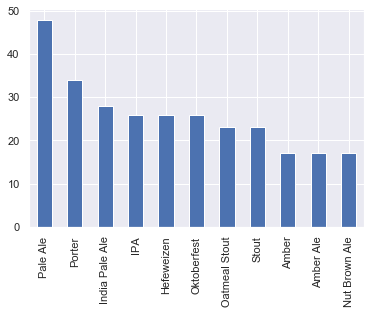

Answer: 
  The top ten names are: 

Pale Ale          48
Porter            34
India Pale Ale    28
IPA               26
Hefeweizen        26
Oktoberfest       26
Stout             23
Oatmeal Stout     23
Nut Brown Ale     17
Amber             17
Name: name, dtype: int64
They are generic and used in maximum 48 times used in this sample (Pale Ale)


In [8]:
#top 10 names
#get occurance of the 10th-often beer name
occurance_10th_value = df_beers["name"].value_counts().sort_values().tail(10).head(1)

#form df with top 10 names and duplicate occurances
df_grouped_names_often = df_beers.groupby("name").filter(lambda x: len(x) > occurance_10th_value-1)

#plot top 10 names and occurances
df_grouped_names_often["name"].value_counts().plot(kind="bar")
plt.show()

print("Answer:" ,"\n"," The top ten names are:", "\n")
print(df_beers["name"].value_counts().sort_values(ascending=False).head(10))
print("They are generic and used in maximum 48 times used in this sample (Pale Ale)")

#Edit: changing the name of the column due to duplicate names with brewery
df_beers["name_beer"] = df_beers["name"]
df_beers.drop("name", axis=1, inplace=True)

### 2. Brewery_id

In [9]:
#explore brewery_id
print(df_beers["brewery_id"].head())
print(df_beers["brewery_id"].describe())

id
1      812
6     1385
8     1099
10     545
13     545
Name: brewery_id, dtype: object
count     4362
unique    1368
top       1072
freq        38
Name: brewery_id, dtype: object


### Observations: Some breweries have a larger variety of beers in this sample. The values are IDs only. We should enhance the dataset with names of the breweries, longitude and latitude to look who, where which beers brew the beers are brewed

***Task: merge with brewery df on brewery_id, change id to name of the brewery, concat longitude and latitude, reorder meaningful***

In [10]:
#make a copy from raw for breweries and geocodes
df_breweries = df_breweries_raw.copy()

#add long and lat from brewery geocodes on brewery_id to brewery table
df_breweries = pd.merge(df_breweries, df_breweries_geocode_raw, how="left", left_on = "id", right_on = "brewery_id")
df_breweries.drop("accuracy", axis=1, inplace = True)
df_breweries.reset_index(inplace=True)


#merge beer with brewery on brewery_id
df_beers_brewery = pd.merge(df_beers, df_breweries[["name", "city", "country", "latitude", "longitude"]] , how="left", left_on="brewery_id" , right_on=df_breweries.index)
df_beers_brewery["name_brewery"] = df_beers_brewery["name"]
df_beers_brewery.drop(["brewery_id","name"], axis=1, inplace=True)



#reorder columns
new_cols = ['name_beer', 'cat_id', 'style_id', 'abv', 'ibu', 'srm', 'upc', 'name_brewery', 'city',
       'country', 'latitude', 'longitude']
df_beers_brewery = df_beers_brewery[new_cols]
df_beers_brewery.head()

,name_beer,cat_id,style_id,abv,ibu,srm,upc,name_brewery,city,country,latitude,longitude
0,Hocus Pocus,11,116,4.5,0,0,0,Mad River Brewing Company,Blue Lake,United States,40.8786,-123.992
1,Winter Warmer,1,13,5.2,0,0,0,Yamhill Brewing,Portland,United States,45.5235,-122.676
2,Oatmeal Stout,3,42,5,0,0,0,Salopian Brewery,Shrewsbury,United Kingdom,52.7069,-2.787
3,Chocolate Stout,3,42,0,0,0,0,Foster's Australia Ltd.,NaN,Australia,NaN,NaN
4,The Kidd Lager,7,86,0,0,0,0,Foster's Australia Ltd.,NaN,Australia,NaN,NaN


***Questions:  ***  
***1. How many different beers are brewed on average per brewery?***   
***2. Which are the top 5 most diverse breweries?***  
***3. What is the avg diversity of beers brewed per brewery per country?***  
***4. In which top 10 countries are the breweries most diverse?***

In [11]:
#1 Group by brewery
df_grouped_brewery = df_beers_brewery.groupby("name_brewery" )
avg_beer_per_brewery = df_grouped_brewery["name_beer"].count().mean()

print("Answer 1: On average(mean) {:.2f} beers are brewed per brewery".format(avg_beer_per_brewery), "\n")

#2 used grouped_object
print("Answer 2: The top 5 most diverse breweries are:")
print(df_grouped_brewery["name_beer"].count().nlargest(5), "\n")

#3 calculate beers/country div by breweries/country
avg_div_per_country = df_beers_brewery.groupby("country")["name_beer"].nunique() / df_beers_brewery.groupby("country")["name_brewery"].nunique()
print("Answer 3: The average diversity in brewed beers per brewerie per country is:" ,"\n",avg_div_per_country.sort_values(ascending = False), "\n")
#4 get largest 10 and make comment on how many breweries are in a country
print("Answer 4: The top ten brewery-diversity countries are:","\n",avg_div_per_country.nlargest(10), "\n")
print("Comment on 4:")
for country in avg_div_per_country.nlargest(10).reset_index()["country"]:
    print(country + " has {} brewery(s)".format(df_beers_brewery.groupby("country").get_group(country)["name_brewery"].nunique()))

Answer 1: On average(mean) 2.86 beers are brewed per brewery 

Answer 2: The top 5 most diverse breweries are:
name_brewery
Middle Ages Brewing      18
The Cambridge House      18
Hoppin Frog Brewery      16
Govnor's Public House    15
Adnams & Co.             14
Name: name_beer, dtype: int64 

Answer 3: The average diversity in brewed beers per brewerie per country is: 
 country
China                 6.000000
Mauritius             5.000000
Namibia               5.000000
Finland               4.000000
Spain                 4.000000
Sierra Leone          4.000000
Panama                4.000000
Japan                 3.800000
Canada                3.200000
United States         2.862884
United Kingdom        2.815789
Czech Republic        2.666667
Norway                2.500000
France                2.400000
Belgium               2.333333
India                 2.250000
Russia                2.000000
Sri Lanka             2.000000
Australia             2.000000
Austria               1.8571

### 3. Cat_id

In [45]:
#Make a copy of beers with brewery for further usage (savepoint)
df_bb = df_beers_brewery.copy()

#Explore
print(df_bb["cat_id"].head())
print(df_bb["cat_id"].describe())
print(df_bb["cat_id"].value_counts())
print(df_bb["cat_id"].dtype)

0    11
1     1
2     3
3     3
4     7
Name: cat_id, dtype: object
count     4362.0
unique      18.0
top          3.0
freq      1248.0
Name: cat_id, dtype: float64
3.0                     1248
3                        724
8.0                      316
7.0                      276
8                        236
1.0                      186
2.0                      180
5                        162
5.0                      160
7                        155
11                       151
4.0                      148
1                        128
11.0                     114
2                        105
4                         68
9.0                        4
 Weyermann Melonodon       1
Name: cat_id, dtype: int64
object


### Results:
* Its a categorical variable
* Too many unique values for categories in categories_raw
* should be replaced by values from df_categories_raw

### Tasks:
0. Clean up the column  
1. Replace IDs with values from df_categories_raw  
2. Change dtype to category

In [47]:
#drop the strange one and change dtype to int64 for merging
print(df_bb[df_bb["cat_id"]==" Weyermann Melonodon"])
df_bb.drop(df_bb[df_bb["cat_id"]==" Weyermann Melonodon"].index, axis=0, inplace=True)
df_bb["cat_id"] = df_bb["cat_id"].astype("float64")

#print value counts to ensure correct dropping
print(df_bb["cat_id"].value_counts())


#Merge with categories_raw
df_bb_cat = pd.merge(df_bb, df_categories_raw[["cat_name"]], how="left", left_on= "cat_id", right_on="id")

#drop cat_id
df_bb_cat.drop("cat_id", axis=1, inplace = True)

#print head to see if everything is fine
print(df_bb_cat.head())
print(df_bb_cat["cat_name"].describe())

Empty DataFrame
Columns: [name_beer, cat_id, style_id, abv, ibu, srm, upc, name_brewery, city, country, latitude, longitude]
Index: []
3.0     1972
8.0      552
7.0      431
5.0      322
1.0      314
2.0      285
11.0     265
4.0      216
9.0        4
Name: cat_id, dtype: int64
         name_beer style_id  abv ibu srm upc               name_brewery  \
0      Hocus Pocus      116  4.5   0   0   0  Mad River Brewing Company   
1    Winter Warmer       13  5.2   0   0   0            Yamhill Brewing   
2    Oatmeal Stout       42    5   0   0   0           Salopian Brewery   
3  Chocolate Stout       42    0   0   0   0    Foster's Australia Ltd.   
4   The Kidd Lager       86    0   0   0   0    Foster's Australia Ltd.   

         city         country  latitude  longitude            cat_name  
0   Blue Lake   United States   40.8786   -123.992         Other Style  
1    Portland   United States   45.5235   -122.676         British Ale  
2  Shrewsbury  United Kingdom   52.7069     -2.787 

***Questions:***  
***1. How are the categories distributed Germany?***  
***2. How is the distribution of North American Ale?***


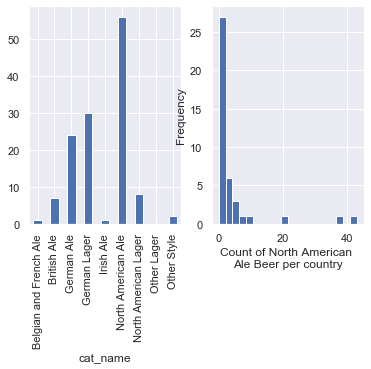

cat_name            Belgian and French Ale  British Ale  German Ale  \
country                                                               
Aruba                                  1.0          0.0         0.0   
Australia                              0.0          0.0         2.0   
Austria                                1.0          0.0         4.0   
Belgium                               40.0          1.0         0.0   
Brazil                                 0.0          0.0         0.0   
Canada                                 3.0          5.0         4.0   
China                                  1.0          0.0         0.0   
Colombia                               0.0          0.0         0.0   
Croatia                                0.0          0.0         1.0   
Czech Republic                         0.0          1.0         0.0   
England                                0.0          0.0         0.0   
Finland                                1.0          0.0         0.0   
France

In [137]:
#Pivoting the table to show it
piv_count_cat_p_country = pd.pivot_table(df_bb_cat, values="name_beer",index="country", columns="cat_name",aggfunc="count")
piv_count_cat_p_country = piv_count_cat_p_country.fillna(0)
fig=plt.figure()

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
piv_count_cat_p_country.loc["Germany",:].plot(kind="bar", ax=ax1)
piv_count_cat_p_country[piv_count_cat_p_country["North American Ale"]<50]["North American Ale"].plot(kind="hist", bins=20, ax=ax2)
ax2.xaxis.set_label_text("Count of North American " + "\n" + "Ale Beer per country")

plt.show()
print(piv_count_cat_p_country)